<a href="https://colab.research.google.com/github/casualcomputer/llm_google_colab/blob/main/setup_crewai_agents_google_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyst agents to auto-explore datasets

**Motivation**

Data analysts live by joins. Combining multiple tables – customer details, sales figures, inventory levels – is fundamental to uncovering deeper business insights. But this process is fragile. The final analysis is only as strong as its weakest data link.

Introduce just one dataset with quality issues into your sequence of joins, and the entire result becomes suspect. The more tables you bring into the mix, the higher the odds that at least one of them is flawed. Suddenly, that five-table join feels much riskier than a simple two-table lookup. This compounding risk underscores a crucial, often time-consuming step: rigorous data quality assessment before merging.

So, how do we typically combat this risk? Before diving into complex joins or modeling, the diligent data analyst performs crucial exploratory data analysis (EDA) and quality checks on each input dataset. This isn't just a single step, but a well-trodden path involving several standard procedures.



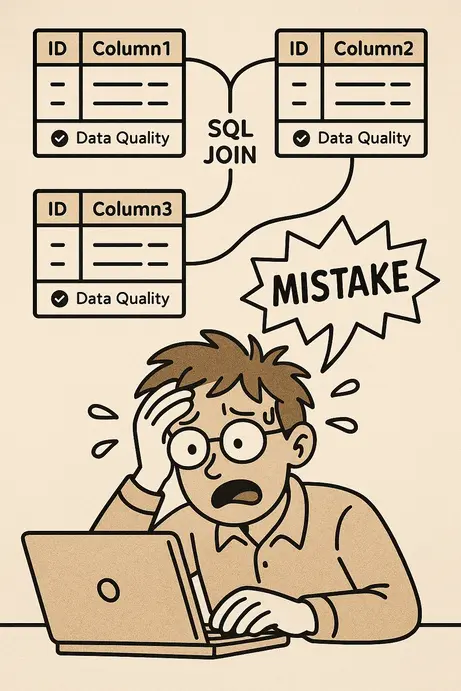

In [5]:
!pip install summarytools langchain-google-genai crewai -q

**Establishing a Data Understanding Baseline**

Before complex analysis, understanding each input dataset is crucial. While experienced analysts develop diverse techniques, a common baseline approach guides most initial data quality checks and exploration. This foundational process typically involves:

1. Missing Values: Calculating the count and percentage of nulls per variable.
2. Continuous Distributions: Examining key statistics (mean, median, min, max, std dev) and outliers, often visualized with histograms.
3. Categorical Frequencies: Identifying unique values, their counts, and potential anomalies in categorical fields.
4. Trend analysis: Tracking key metrics over time (if applicable) to spot patterns or shifts.
5. etc.

The example belows demonstrates using "summarytools" package in Python to summarize the famous titanic dataset.

In [18]:
import pandas as pd # load example dataset
from summarytools import dfSummary
titanic = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')
df_summary_info = dfSummary(titanic)
df_summary_info

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,PassengerId[int64],Mean (sd) : 446.0 (257.4)min < med < max:1.0 < 446.0 < 891.0IQR (CV) : 445.0 (1.7),891 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAfBJREFUeJzt179u2mAYR+HXVopMQLb4U7iAjt2QWLiAjr3YXgRDZ4YundiQkGWEm6gWddcsSTFWk57qPCv8eL/hDEnStm1I/7r0rR8gXePurR+g/0eSJMOIGNw4/9m27cNzH/4x1J7H04j4deO27556m/rubDqdfiqKYnTL+HQ6lUmSfHku1hdDTZJkOJvNPud5Pul6+HK5vKvr+sN4PP6epmnzmnvqbeq7IyKapski4uN6vf46n89PXbZVVWXb7XZyPB4HEdE91IgY5Hk+2Ww2D0VRPHY5vt/vJ7vd7v1qtfq2XC7LLtu+e+pt6ruf7O+zLGsWi8WPrvuIGL704VV/oxZF8dj1eFmWw4iI0WjUedt3T71NfffT/d/if/1CMFQhGKoQDFUIhioEQxWCoQrBUIVgqEIwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVgqEKwVCFYKhCMFQhGKoQDFUIhioEQxWCoQrBUIVgqEIwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVgqEKwVCFYKhCMFQhGKoQDFUIhioEQxWCoQrBUIVgqEIwVCEYqhAMVQiGKgRDFcLdNV+qqirr+sPn8zmLiKjrOjscDvevuafepr677/6avn4DnvQ0vvDadOQAAAAASUVORK5CYII="">",0(0.0%)
2,Survived[int64],1. 02. 1,549 (61.6%)342 (38.4%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAATRJREFUeJzt20FqwzAURdGvYkIzkTAGLyaL6GK7CO3GGGvQhEzUQffwJPruWcFPuBgS/FLvPQCFFBH3iLiNPsTYu/f+HH2EwrJt21fOeR19iKvW2plS+nYIbsk5r4/H41lKeY0+xs11XZ+11vU4jltE/P/YIiJKKa99339GH2PqPvoAlY/RB8AHsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMkvE30t8ow9x5Pa9L621s9a6htFLfDNprZ0R8R59hwKDl/FsBi+JKR9U3J5sNk+RGVlN+ZxmczOymfK5zeZm5Dbl4xf3QPypCxligwyxQYbYIENskCE2yBAbZIgNMsQGGWKDDLFBhtggQ2yQITbIEBtkbKZ8Dp9xdlZTPqfZ3IwYvEDmFwpbat+w550qAAAAAElFTkSuQmCC"">",0(0.0%)
3,Pclass[int64],1. 32. 13. 2,491 (55.1%)216 (24.2%)184 (20.7%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAZdJREFUeJzt20Fq22AUhdGnIkIzkTAGL8aL6GK7CO3GGGuQhEyUQSYttLPk/j/SOSt4mA8bCd9h27aChB+tD+A4hqp6rqqn1ofszPu2ba+tj+jNeD6ff03TdGp9yJ6s63ofhuG34P42TtN0ul6vr/M8v7U+Zg8ej8fPZVlOt9vtqarE9oexqmqe57fL5fLS+pgdeW59QI88IBAjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjZqz6/A9W60P2wmf5f+O6rvdlWU7lP1hfZl3Xe1W9t76jNzYI38MG4R8GUz5Sev5m8+2wM92uqyyU9qfLdZWF0j71vK7ydLwzXuoSIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI6bLdVVv9/A1ul1XWSjtjw0CMdZVxHhAIKaHn1E/lwfRfMpnsnccTad8JnvH0sOUr6tXLnwfDwjEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiGk65TPZO5bmUz6TveOwQSDGlI+YD0q8o0pBCWgtAAAAAElFTkSuQmCC"">",0(0.0%)
4,Name[object],"1. Dooley, Mr. Patrick2. Braund, Mr. Owen Harris3. Cumings, Mrs. John Bradley (Fl4. Heikkinen, Miss. Laina5. Futrelle, Mrs. Jacques Heath (6. Allen, Mr. William Henry7. Moran, Mr. James8. McCarthy, Mr. Timothy J9. Palsson, Master. Gosta Leonard10. Johnson, Mrs. Oscar W (Elisabe11. other",1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)881 (98.9%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAA1xJREFUeJzt3MFpG2EURtE3Rjj2RkIYXELSg4tIsSlCRaQHYzyL2PFmskgWKSDcAeWcCv7FhYdgPi3btg0UbvZ+AP8PsZERGxmxkREbGbGRERsZsZERGxmxkblZluXLsix3ez+E63czM59n5tPeD+H6OaNkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERuZmZr7PzM+9H8L1W/yLERVnlIzYyFhXkbGuIuOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhklIzYyBi9kDF7IOKNkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGQMXsgYvJBxRsmIjYzYyFhXkbGuIuOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRsa4iY11FxhklIzYyBi9kDF7IOKNkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGQMXsgYvJBxRsmIjYzBCxmDFzLOKBmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRsa4iY11FxhklIzYy1lVkrKvIOKNkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGQMXsgYvJBxRsmIjYzBCxmDFzLOKBmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxk

We are removing the image tags that visualize categorical variable distributions (under the "graph" column) from the dataset summary. This step ensures the remaining results can be saved purely as text in a .txt file, making it suitable for processing by an LLM.

In [19]:
print("Original Text:")
print(df_summary_info.to_string())

import re

def remove_img_texts(html_text: str) -> str:
    """
    Removes any text between <img ... </img> tags (including the tags)
    from the given text.
    """
    # This pattern matches an <img> tag with any attributes, followed by any content until a </img> tag.
    pattern = re.compile(r'<img[^>]*>.*?</img>', re.DOTALL | re.IGNORECASE)
    cleaned_text = pattern.sub('', html_text)
    return cleaned_text

# Example usage:
result = remove_img_texts(df_summary_info.to_string())
print("\nCleaned Text:")
print(result)

# Optionally, save the cleaned text to a text file.
with open("df_summary_text.txt", "w") as f:
    f.write(result)

# TODO: apply custom instructions on each row of text. instruct-fine tune, error rate analysis with custom dashboards or just version control of prompts and results like latitude

Original Text:
No Variable Stats / Values Freqs / (% of Valid) Graph Missing
1 <strong>PassengerId</strong><br>[int64] Mean (sd) : 446.0 (257.4)<br>min < med < max:<br>1.0 < 446.0 < 891.0<br>IQR (CV) : 445.0 (1.7) 891 distinct values <img src = "data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAfBJREFUeJzt179u2mAYR+HXVopMQLb4U7iAjt2QWLiAjr3YXgRDZ4YundiQkGWEm6gWddcsSTFWk57qPCv8eL/hDEnStm1I/7r0rR8gXePurR+g/0eSJMOIGNw4/9m27cNzH/4x1J7H04j4deO27556m/rubDqdfiqKYnTL+HQ6lUmSfHku1hdDTZJkOJvNPud5Pul6+HK5vKvr+sN4PP6epmnzmnvqbeq7IyKapski4uN6vf46n89PXbZVVWXb7XZyPB4HEdE91IgY5Hk+2Ww2D0VRPHY5vt/vJ7vd7v1qtfq2XC7LLtu+e+pt6ruf7O+zLGsWi8WPrvuIGL704VV/oxZF8dj1eFmWw4iI0WjUedt3T71NfffT/d/if/1CMFQhGKoQDFUIhioEQxWCoQrBUIVgqEIwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVgqEKwVCFYKhCMFQhGKoQDFUIhioEQxWCoQrBUIVgqEIwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVgqEKwVC

# Agent to mimic data analyst and other roles

## Input the Gemini API from Google AI Studio

In [ ]:
api_key = input("Please enter your API key: ")
os.environ["GEMINI_API_KEY"] = api_key
print("API key has been set.")

In [17]:
import os
import pandas as pd
from crewai import Agent, Task, Crew, Process
from langchain_google_genai import ChatGoogleGenerativeAI
from summarytools import dfSummary
from crewai import Agent, Task, Crew, LLM

llm = LLM(model="gemini/gemini-2.0-flash")

# -----------------------------------------------------------------------------
# 2) Load the Titanic dataset and generate a text summary using summarytools.
#
# The dfSummary() output (a pandas Styler) is converted to plain text with .to_string().
# -----------------------------------------------------------------------------
titanic = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")
df_summary_info = dfSummary(titanic).to_string()

# -----------------------------------------------------------------------------
# 3) Create AI team agents in a CrewAI style.
#
# Each agent is provided with a role, goal, and backstory. They use Gemini Pro via llm.
# -----------------------------------------------------------------------------
data_quality_agent = Agent(
    role="Data Quality Analyst",
    goal="Identify columns with data quality issues such as those with more than 20% missing values.",
    backstory="An experienced data analyst who excels at detecting data quality issues and anomalies in datasets.",
    verbose=True,
    allow_delegation=False,
    llm=llm
)

statistical_agent = Agent(
    role="Statistical Analyst",
    goal="Examine numeric columns for potential outliers where maximum values greatly exceed the mean.",
    backstory="A meticulous statistician with expertise in numeric data distributions and anomaly detection.",
    verbose=True,
    allow_delegation=False,
    llm=llm
)

insight_agent = Agent(
    role="Predictive Modeling Advisor",
    goal="Recommend which columns appear most informative for predictive modeling.",
    backstory="A seasoned machine learning consultant skilled in feature engineering and predictive analysis.",
    verbose=True,
    allow_delegation=True,
    llm=llm
)

# -----------------------------------------------------------------------------
# 4) Create tasks for each agent by embedding the dataset summary (as text).
#
# Note: We now include an 'expected_output' field as required by the Task model.
# -----------------------------------------------------------------------------
task1 = Task(
    description=f"""Data Quality Task:
Examine the dataset summary below and identify columns with significant data quality issues or concerns.
Focus primarily on those columns with more than 20% missing values, and consider columns with unusual uniqueness metrics.
Provide detailed insights including the percentage of missing data and any recommendations for cleaning.
Dataset Summary:
{df_summary_info}""",
    expected_output="A detailed list of column names with significant missing data issues along with insights and recommendations for data cleaning.",
    agent=data_quality_agent
)


task2 = Task(
    description=f"""Statistical Analysis Task:
Review the dataset summary below and identify any numeric columns that exhibit potential outlier behavior.
Specifically, look for columns where the maximum value far exceeds the mean (e.g., max > 3 × mean) and any unusual spread in the data.
Include a brief explanation of why each identified column may be problematic. Provide any recommendations for further investigation.
Dataset Summary:
{df_summary_info}""",
    expected_output="A detailed list of numeric columns with potential outlier issues, including a brief explanation for each.",
    agent=statistical_agent
)


task3 = Task(
    description=f"""Predictive Modeling Insight Task:
Based on the dataset summary below, recommend which columns might be most informative for building a predictive model.
Dataset Summary:
{df_summary_info}""",
    expected_output="A list of column names that are likely to be most informative for predictive modeling.",
    agent=insight_agent
)

# -----------------------------------------------------------------------------
# 5) Assemble the Crew and execute the tasks sequentially.
#
# The Crew (ManagerAgent) runs the tasks one by one.
# -----------------------------------------------------------------------------
crew = Crew(
    agents=[data_quality_agent, statistical_agent, insight_agent],
    tasks=[task1, task2, task3],
    verbose=True,
    process=Process.sequential,
)

crew_output = crew.kickoff()

print("\nCrew Output:")
print(crew_output)


╭──────────────────────────────────────────── Crew Execution Started ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name: crew                                                                                                     │
│  ID: fb25122b-a197-4be3-98e2-7187488389ea                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🚀 Crew: crew
└── 📋 Task: 1a1b12c0-5c13-40bc-87fb-2111b26a0890
       Status: Executing Task...

🚀 Crew: crew
└── 📋 Task: 1a1b12c0-5c13-40bc-87fb-2111b26a0890
       Status: Executing Task...
    └── 🤖 Agent: Data Quality Analyst
            Status: In Progress

# Agent: Data Quality Analyst
## Task: Data Quality Task:
Examine the dataset summary below and identify columns with significant data quality issues or concerns.
Focus primarily on those columns with more than 20% missing values, and consider columns with unusual uniqueness metrics.
Provide detailed insights including the percentage of missing data and any recommendations for cleaning.
Dataset Summary:
No Variable Stats / Values Freqs / (% of Valid) Graph Missing
1 <strong>PassengerId</strong><br>[int64] Mean (sd) : 446.0 (257.4)<br>min < med < max:<br>1.0 < 446.0 < 891.0<br>IQR (CV) : 445.0 (1.7) 891 distinct values <img src = "data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAfBJREFUeJzt179u2mAYR+HXVopMQLb4U7iAjt2QWLiAjr3YXgRDZ4YundiQkGWEm6gWddcsSTFWk57qPCv8eL/hDEnStm1I/7r0rR8gXePurR+g/0eSJMOIGNw4/9m27cNzH/4x1J7H04j4deO27556m/rubDqdfiqKYnTL+HQ

🚀 Crew: crew
└── 📋 Task: 1a1b12c0-5c13-40bc-87fb-2111b26a0890
       Status: Executing Task...
    └── 🤖 Agent: Data Quality Analyst
            Status: ✅ Completed

🚀 Crew: crew
└── 📋 Task: 1a1b12c0-5c13-40bc-87fb-2111b26a0890
       Assigned to: Data Quality Analyst
       Status: ✅ Completed
    └── 🤖 Agent: Data Quality Analyst
            Status: ✅ Completed

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: 1a1b12c0-5c13-40bc-87fb-2111b26a0890                                                                     │
│  Agent: Data Quality Analyst                                                                                    │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🚀 Crew: crew
├── 📋 Task: 1a1b12c0-5c13-40bc-87fb-2111b26a0890
│      Assigned to: Data Quality Analyst
│      Status: ✅ Completed
│   └── 🤖 Agent: Data Quality Analyst
│           Status: ✅ Completed
└── 📋 Task: 8eedb141-4888-4153-adab-2eefd60cf4ad
       Status: Executing Task...

🚀 Crew: crew
├── 📋 Task: 1a1b12c0-5c13-40bc-87fb-2111b26a0890
│      Assigned to: Data Quality Analyst
│      Status: ✅ Completed
│   └── 🤖 Agent: Data Quality Analyst
│           Status: ✅ Completed
└── 📋 Task: 8eedb141-4888-4153-adab-2eefd60cf4ad
       Status: Executing Task...
    └── 🤖 Agent: Statistical Analyst
            Status: In Progress

# Agent: Statistical Analyst
## Task: Statistical Analysis Task:
Review the dataset summary below and identify any numeric columns that exhibit potential outlier behavior.
Specifically, look for columns where the maximum value far exceeds the mean (e.g., max > 3 × mean) and any unusual spread in the data.
Include a brief explanation of why each identified column may be problematic. Provide any recommendations for further investigation.
Dataset Summary:
No Variable Stats / Values Freqs / (% of Valid) Graph Missing
1 <strong>PassengerId</strong><br>[int64] Mean (sd) : 446.0 (257.4)<br>min < med < max:<br>1.0 < 446.0 < 891.0<br>IQR (CV) : 445.0 (1.7) 891 distinct values <img src = "data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAfBJREFUeJzt179u2mAYR+HXVopMQLb4U7iAjt2QWLiAjr3YXgRDZ4YundiQkGWEm6gWddcsSTFWk57qPCv8eL/hDEnStm1I/7r0rR8gXePurR+g/0eSJMOIG

🚀 Crew: crew
├── 📋 Task: 1a1b12c0-5c13-40bc-87fb-2111b26a0890
│      Assigned to: Data Quality Analyst
│      Status: ✅ Completed
│   └── 🤖 Agent: Data Quality Analyst
│           Status: ✅ Completed
└── 📋 Task: 8eedb141-4888-4153-adab-2eefd60cf4ad
       Status: Executing Task...
    └── 🤖 Agent: Statistical Analyst
            Status: ✅ Completed

🚀 Crew: crew
├── 📋 Task: 1a1b12c0-5c13-40bc-87fb-2111b26a0890
│      Assigned to: Data Quality Analyst
│      Status: ✅ Completed
│   └── 🤖 Agent: Data Quality Analyst
│           Status: ✅ Completed
└── 📋 Task: 8eedb141-4888-4153-adab-2eefd60cf4ad
       Assigned to: Statistical Analyst
       Status: ✅ Completed
    └── 🤖 Agent: Statistical Analyst
            Status: ✅ Completed

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: 8eedb141-4888-4153-adab-2eefd60cf4ad                                                                     │
│  Agent: Statistical Analyst                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🚀 Crew: crew
├── 📋 Task: 1a1b12c0-5c13-40bc-87fb-2111b26a0890
│      Assigned to: Data Quality Analyst
│      Status: ✅ Completed
│   └── 🤖 Agent: Data Quality Analyst
│           Status: ✅ Completed
├── 📋 Task: 8eedb141-4888-4153-adab-2eefd60cf4ad
│      Assigned to: Statistical Analyst
│      Status: ✅ Completed
│   └── 🤖 Agent: Statistical Analyst
│           Status: ✅ Completed
└── 📋 Task: aeb9dae7-a36c-4e1f-a4f7-968f7e6e0145
       Status: Executing Task...

🚀 Crew: crew
├── 📋 Task: 1a1b12c0-5c13-40bc-87fb-2111b26a0890
│      Assigned to: Data Quality Analyst
│      Status: ✅ Completed
│   └── 🤖 Agent: Data Quality Analyst
│           Status: ✅ Completed
├── 📋 Task: 8eedb141-4888-4153-adab-2eefd60cf4ad
│      Assigned to: Statistical Analyst
│      Status: ✅ Completed
│   └── 🤖 Agent: Statistical Analyst
│           Status: ✅ Completed
└── 📋 Task: aeb9dae7-a36c-4e1f-a4f7-968f7e6e0145
       Status: Executing Task...
    └── 🤖 Agent: Predictive Modeling Advisor
            Status: In Progress

# Agent: Predictive Modeling Advisor
## Task: Predictive Modeling Insight Task:
Based on the dataset summary below, recommend which columns might be most informative for building a predictive model.
Dataset Summary:
No Variable Stats / Values Freqs / (% of Valid) Graph Missing
1 <strong>PassengerId</strong><br>[int64] Mean (sd) : 446.0 (257.4)<br>min < med < max:<br>1.0 < 446.0 < 891.0<br>IQR (CV) : 445.0 (1.7) 891 distinct values <img src = "data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAfBJREFUeJzt179u2mAYR+HXVopMQLb4U7iAjt2QWLiAjr3YXgRDZ4YundiQkGWEm6gWddcsSTFWk57qPCv8eL/hDEnStm1I/7r0rR8gXePurR+g/0eSJMOIGNw4/9m27cNzH/4x1J7H04j4deO27556m/rubDqdfiqKYnTL+HQ6lUmSfHku1hdDTZJkOJvNPud5Pul6+HK5vKvr+sN4PP6epmnzmnvqbeq7IyKapski4uN6vf46n89PXbZVVWXb7XZyPB4HEdE91IgY5Hk+2Ww2D0VRPHY5vt/vJ7vd7v1qtfq2XC7LLtu+e+pt6ruf7O+zLGsWi8WPrvuIGL704VV/oxZF8dj1eFmWw4iI0W

🤖 Agent: Predictive Modeling Advisor
    Status: In Progress

🚀 Crew: crew
├── 📋 Task: 1a1b12c0-5c13-40bc-87fb-2111b26a0890
│      Assigned to: Data Quality Analyst
│      Status: ✅ Completed
│   └── 🤖 Agent: Data Quality Analyst
│           Status: ✅ Completed
├── 📋 Task: 8eedb141-4888-4153-adab-2eefd60cf4ad
│      Assigned to: Statistical Analyst
│      Status: ✅ Completed
│   └── 🤖 Agent: Statistical Analyst
│           Status: ✅ Completed
└── 📋 Task: aeb9dae7-a36c-4e1f-a4f7-968f7e6e0145
       Status: Executing Task...
    ├── 🤖 Agent: Predictive Modeling Advisor
    │       Status: In Progress
    └── 🤖 Agent: Data Quality Analyst
            Status: In Progress

# Agent: Data Quality Analyst
## Task: Based on the data quality assessment I have, the columns 'Age', 'Cabin', and 'Embarked' have missing values. 'Age' has about 20% missing, 'Cabin' has 77% missing, and 'Embarked' has very few. I plan to impute 'Age' using mean/median/regression, create a 'Cabin_Known' binary feature for 'Cabin', and impute 'Embarked' using the mode. Do you agree with this approach? Are there any alternative strategies or potential pitfalls I should be aware of before moving forward with these columns in predictive modeling?


# Agent: Data Quality Analyst
## Final Answer: 
Your proposed strategies are a good starting point. Refine your approach to 'Age' by exploring different imputation techniques (including regression with caution, and considering a missingness indicator). Your approach to 'Cabin' is excellent. Your approach to 'Embarked' is appropriate given the small number of missing values. Remember to perform a thorough missing data analysis, document your st

🚀 Crew: crew
├── 📋 Task: 1a1b12c0-5c13-40bc-87fb-2111b26a0890
│      Assigned to: Data Quality Analyst
│      Status: ✅ Completed
│   └── 🤖 Agent: Data Quality Analyst
│           Status: ✅ Completed
├── 📋 Task: 8eedb141-4888-4153-adab-2eefd60cf4ad
│      Assigned to: Statistical Analyst
│      Status: ✅ Completed
│   └── 🤖 Agent: Statistical Analyst
│           Status: ✅ Completed
└── 📋 Task: aeb9dae7-a36c-4e1f-a4f7-968f7e6e0145
       Status: Executing Task...
    ├── 🤖 Agent: Predictive Modeling Advisor
    │       Status: In Progress
    └── 🤖 Agent: Data Quality Analyst
            Status: ✅ Completed



# Agent: Predictive Modeling Advisor
## Thought: Okay, I need to recommend columns that might be most informative for building a predictive model, and I have some context about data quality and potential outliers to consider.
First, I'll ask the Data Quality Analyst to confirm my assessment of how to handle the missing values, as that could impact the utility of those columns. Then, I'll ask the Statistical Analyst to provide insight into which of the columns with potential outliers might be most useful for predictive modeling, even with the outliers.
## Using tool: Ask question to coworker
## Tool Input: 
"{\"question\": \"Based on the data quality assessment I have, the columns 'Age', 'Cabin', and 'Embarked' have missing values. 'Age' has about 20% missing, 'Cabin' has 77% missing, and 'Embarked' has very few. I plan to impute 'Age' using mean/median/regression, create a 'Cabin_Known' binary feature for 'Cabin', and impute 'Embarked' using the mode. Do you agree with this approach?

🤖 Agent: Data Quality Analyst
    Status: ✅ Completed
└── 🧠 Thinking...

🤖 Agent: Data Quality Analyst
    Status: ✅ Completed

🤖 Agent: Data Quality Analyst
    Status: ✅ Completed

🚀 Crew: crew
├── 📋 Task: 1a1b12c0-5c13-40bc-87fb-2111b26a0890
│      Assigned to: Data Quality Analyst
│      Status: ✅ Completed
│   └── 🤖 Agent: Data Quality Analyst
│           Status: ✅ Completed
├── 📋 Task: 8eedb141-4888-4153-adab-2eefd60cf4ad
│      Assigned to: Statistical Analyst
│      Status: ✅ Completed
│   └── 🤖 Agent: Statistical Analyst
│           Status: ✅ Completed
└── 📋 Task: aeb9dae7-a36c-4e1f-a4f7-968f7e6e0145
       Status: Executing Task...
    ├── 🤖 Agent: Predictive Modeling Advisor
    │       Status: In Progress
    ├── 🤖 Agent: Data Quality Analyst
    │       Status: ✅ Completed
    └── 🤖 Agent: Statistical Analyst
            Status: In Progress

# Agent: Statistical Analyst
## Task: Based on the dataset summary, 'Fare' and 'Age' exhibit potential outlier behavior, where the maximum values are significantly larger than the mean. I plan to investigate the distributions and potentially apply transformations (e.g., log transform) or capping/flooring. Do you think these columns, even with potential outliers, are likely to be informative for predicting 'Survived'? Are there any other columns that I should examine for potential non-linear relationships or interactions with other features that might be relevant for predictive modeling?


# Agent: Statistical Analyst
## Final Answer: 
Yes, even with potential outliers, both 'Fare' and 'Age' are likely to be informative for predicting 'Survived.' Here's why:

*   **Fare:** Ticket fare is often correlated with socio-economic status, which historically has a strong relationship with survival rates on the Titanic. Higher fares typically meant a higher class cabin located on upper decks, wh

🚀 Crew: crew
├── 📋 Task: 1a1b12c0-5c13-40bc-87fb-2111b26a0890
│      Assigned to: Data Quality Analyst
│      Status: ✅ Completed
│   └── 🤖 Agent: Data Quality Analyst
│           Status: ✅ Completed
├── 📋 Task: 8eedb141-4888-4153-adab-2eefd60cf4ad
│      Assigned to: Statistical Analyst
│      Status: ✅ Completed
│   └── 🤖 Agent: Statistical Analyst
│           Status: ✅ Completed
└── 📋 Task: aeb9dae7-a36c-4e1f-a4f7-968f7e6e0145
       Status: Executing Task...
    ├── 🤖 Agent: Predictive Modeling Advisor
    │       Status: In Progress
    ├── 🤖 Agent: Data Quality Analyst
    │       Status: ✅ Completed
    └── 🤖 Agent: Statistical Analyst
            Status: ✅ Completed



# Agent: Predictive Modeling Advisor
## Thought: Thought: Now that the Data Quality Analyst has confirmed my assessment, I can ask the Statistical Analyst to help determine the most useful columns for the predictive model, given the potential outlier issues.
## Using tool: Ask question to coworker
## Tool Input: 
"{\"question\": \"Based on the dataset summary, 'Fare' and 'Age' exhibit potential outlier behavior, where the maximum values are significantly larger than the mean. I plan to investigate the distributions and potentially apply transformations (e.g., log transform) or capping/flooring. Do you think these columns, even with potential outliers, are likely to be informative for predicting 'Survived'? Are there any other columns that I should examine for potential non-linear relationships or interactions with other features that might be relevant for predictive modeling?\", \"context\": \"Dataset has potential outlier issues in 'Fare' and 'Age' columns. Need to know if they are 

🤖 Agent: Statistical Analyst
    Status: ✅ Completed
└── 🧠 Thinking...

🤖 Agent: Statistical Analyst
    Status: ✅ Completed



# Agent: Predictive Modeling Advisor
## Final Answer: 
['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Name', 'Cabin']




🚀 Crew: crew
├── 📋 Task: 1a1b12c0-5c13-40bc-87fb-2111b26a0890
│      Assigned to: Data Quality Analyst
│      Status: ✅ Completed
│   └── 🤖 Agent: Data Quality Analyst
│           Status: ✅ Completed
├── 📋 Task: 8eedb141-4888-4153-adab-2eefd60cf4ad
│      Assigned to: Statistical Analyst
│      Status: ✅ Completed
│   └── 🤖 Agent: Statistical Analyst
│           Status: ✅ Completed
└── 📋 Task: aeb9dae7-a36c-4e1f-a4f7-968f7e6e0145
       Status: Executing Task...
    ├── 🤖 Agent: Predictive Modeling Advisor
    │       Status: In Progress
    ├── 🤖 Agent: Data Quality Analyst
    │       Status: ✅ Completed
    └── 🤖 Agent: Predictive Modeling Advisor
            Status: ✅ Completed

🚀 Crew: crew
├── 📋 Task: 1a1b12c0-5c13-40bc-87fb-2111b26a0890
│      Assigned to: Data Quality Analyst
│      Status: ✅ Completed
│   └── 🤖 Agent: Data Quality Analyst
│           Status: ✅ Completed
├── 📋 Task: 8eedb141-4888-4153-adab-2eefd60cf4ad
│      Assigned to: Statistical Analyst
│      Status: ✅ Completed
│   └── 🤖 Agent: Statistical Analyst
│           Status: ✅ Completed
└── 📋 Task: aeb9dae7-a36c-4e1f-a4f7-968f7e6e0145
       Assigned to: Predictive Modeling Advisor
       Status: ✅ Completed
    ├── 🤖 Agent: Predictive Modeling Advisor
    │       Status: In Progress
    ├── 🤖 Agent: Data Quality Analyst
    │       Status: ✅ Completed
    └── 🤖 Agent: Predictive Modeling Advisor
            Status: ✅ Completed

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: aeb9dae7-a36c-4e1f-a4f7-968f7e6e0145                                                                     │
│  Agent: Predictive Modeling Advisor                                                                             │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name: crew                                                                                                     │
│  ID: fb25122b-a197-4be3-98e2-7187488389ea                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯


Crew Output:
['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Name', 'Cabin']
